In [2]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchattacks
import os

In [3]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32*2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32*2, 64*2, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64*2, 128*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128*2, 128*2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128*2, 256*2, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256*2 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    
    def forward(self, x):
        # First conv block
        x = self.tanh(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [4]:
trainloader, testloader = load_cifar10()

In [5]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 6,341,002


In [6]:
# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            out = model(inputs)

            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 != 0:
                running_loss += loss.item()
                _, predicted = out.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Evaluation function
def evaluate_model(model, testloader):
    device = 'mps'
    model.eval()
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_acc = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
    
    print('\nPer-class accuracies:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return overall_acc

In [7]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
Epoch: 1/10, Batch: 99, Loss: 1.8948, Acc: 22.14%
Epoch: 1/10, Batch: 199, Loss: 1.6239, Acc: 28.68%
Epoch: 1/10, Batch: 299, Loss: 1.5583, Acc: 33.63%
Epoch 1 completed: Loss: 1.5219, Accuracy: 36.86%
Epoch: 2/10, Batch: 99, Loss: 1.2600, Acc: 52.88%
Epoch: 2/10, Batch: 199, Loss: 1.2178, Acc: 54.47%
Epoch: 2/10, Batch: 299, Loss: 1.1211, Acc: 55.89%
Epoch 2 completed: Loss: 1.0600, Accuracy: 57.44%
Epoch: 3/10, Batch: 99, Loss: 0.8409, Acc: 63.96%
Epoch: 3/10, Batch: 199, Loss: 0.8666, Acc: 64.91%
Epoch: 3/10, Batch: 299, Loss: 0.8798, Acc: 65.99%
Epoch 3 completed: Loss: 0.8380, Accuracy: 66.74%
Epoch: 4/10, Batch: 99, Loss: 0.9061, Acc: 70.94%
Epoch: 4/10, Batch: 199, Loss: 0.6008, Acc: 71.52%
Epoch: 4/10, Batch: 299, Loss: 0.7397, Acc: 72.05%
Epoch 4 completed: Loss: 0.7000, Accuracy: 72.46%
Epoch: 5/10, Batch: 99, Loss: 0.7695, Acc: 75.34%
Epoch: 5/10, Batch: 199, Loss: 0.8407, Acc: 75.35%
Epoch: 5/10, Batch: 299, Loss: 0.6222, Acc: 75.89%
Ep

python(57582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 9/10, Batch: 99, Loss: 0.5068, Acc: 83.46%
Epoch: 9/10, Batch: 199, Loss: 0.5114, Acc: 83.25%
Epoch: 9/10, Batch: 299, Loss: 0.3132, Acc: 83.48%
Epoch 9 completed: Loss: 0.4225, Accuracy: 83.52%


python(57589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 10/10, Batch: 99, Loss: 0.3671, Acc: 84.77%
Epoch: 10/10, Batch: 199, Loss: 0.4184, Acc: 84.25%
Epoch: 10/10, Batch: 299, Loss: 0.4952, Acc: 84.14%
Epoch 10 completed: Loss: 0.4031, Accuracy: 84.33%


In [8]:
filepath='tahn_model.pth'

os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
torch.save(model.state_dict(), filepath)

print(f"Model saved to {filepath}")

Model saved to tahn_model.pth


# Time for some wiggles

In [49]:
def wiggly_tanh(x):
    return nn.functional.tanh(x) + 0.005*torch.sin(100 * x)

In [50]:
x = torch.arange(-5, 5.01, 0.01)

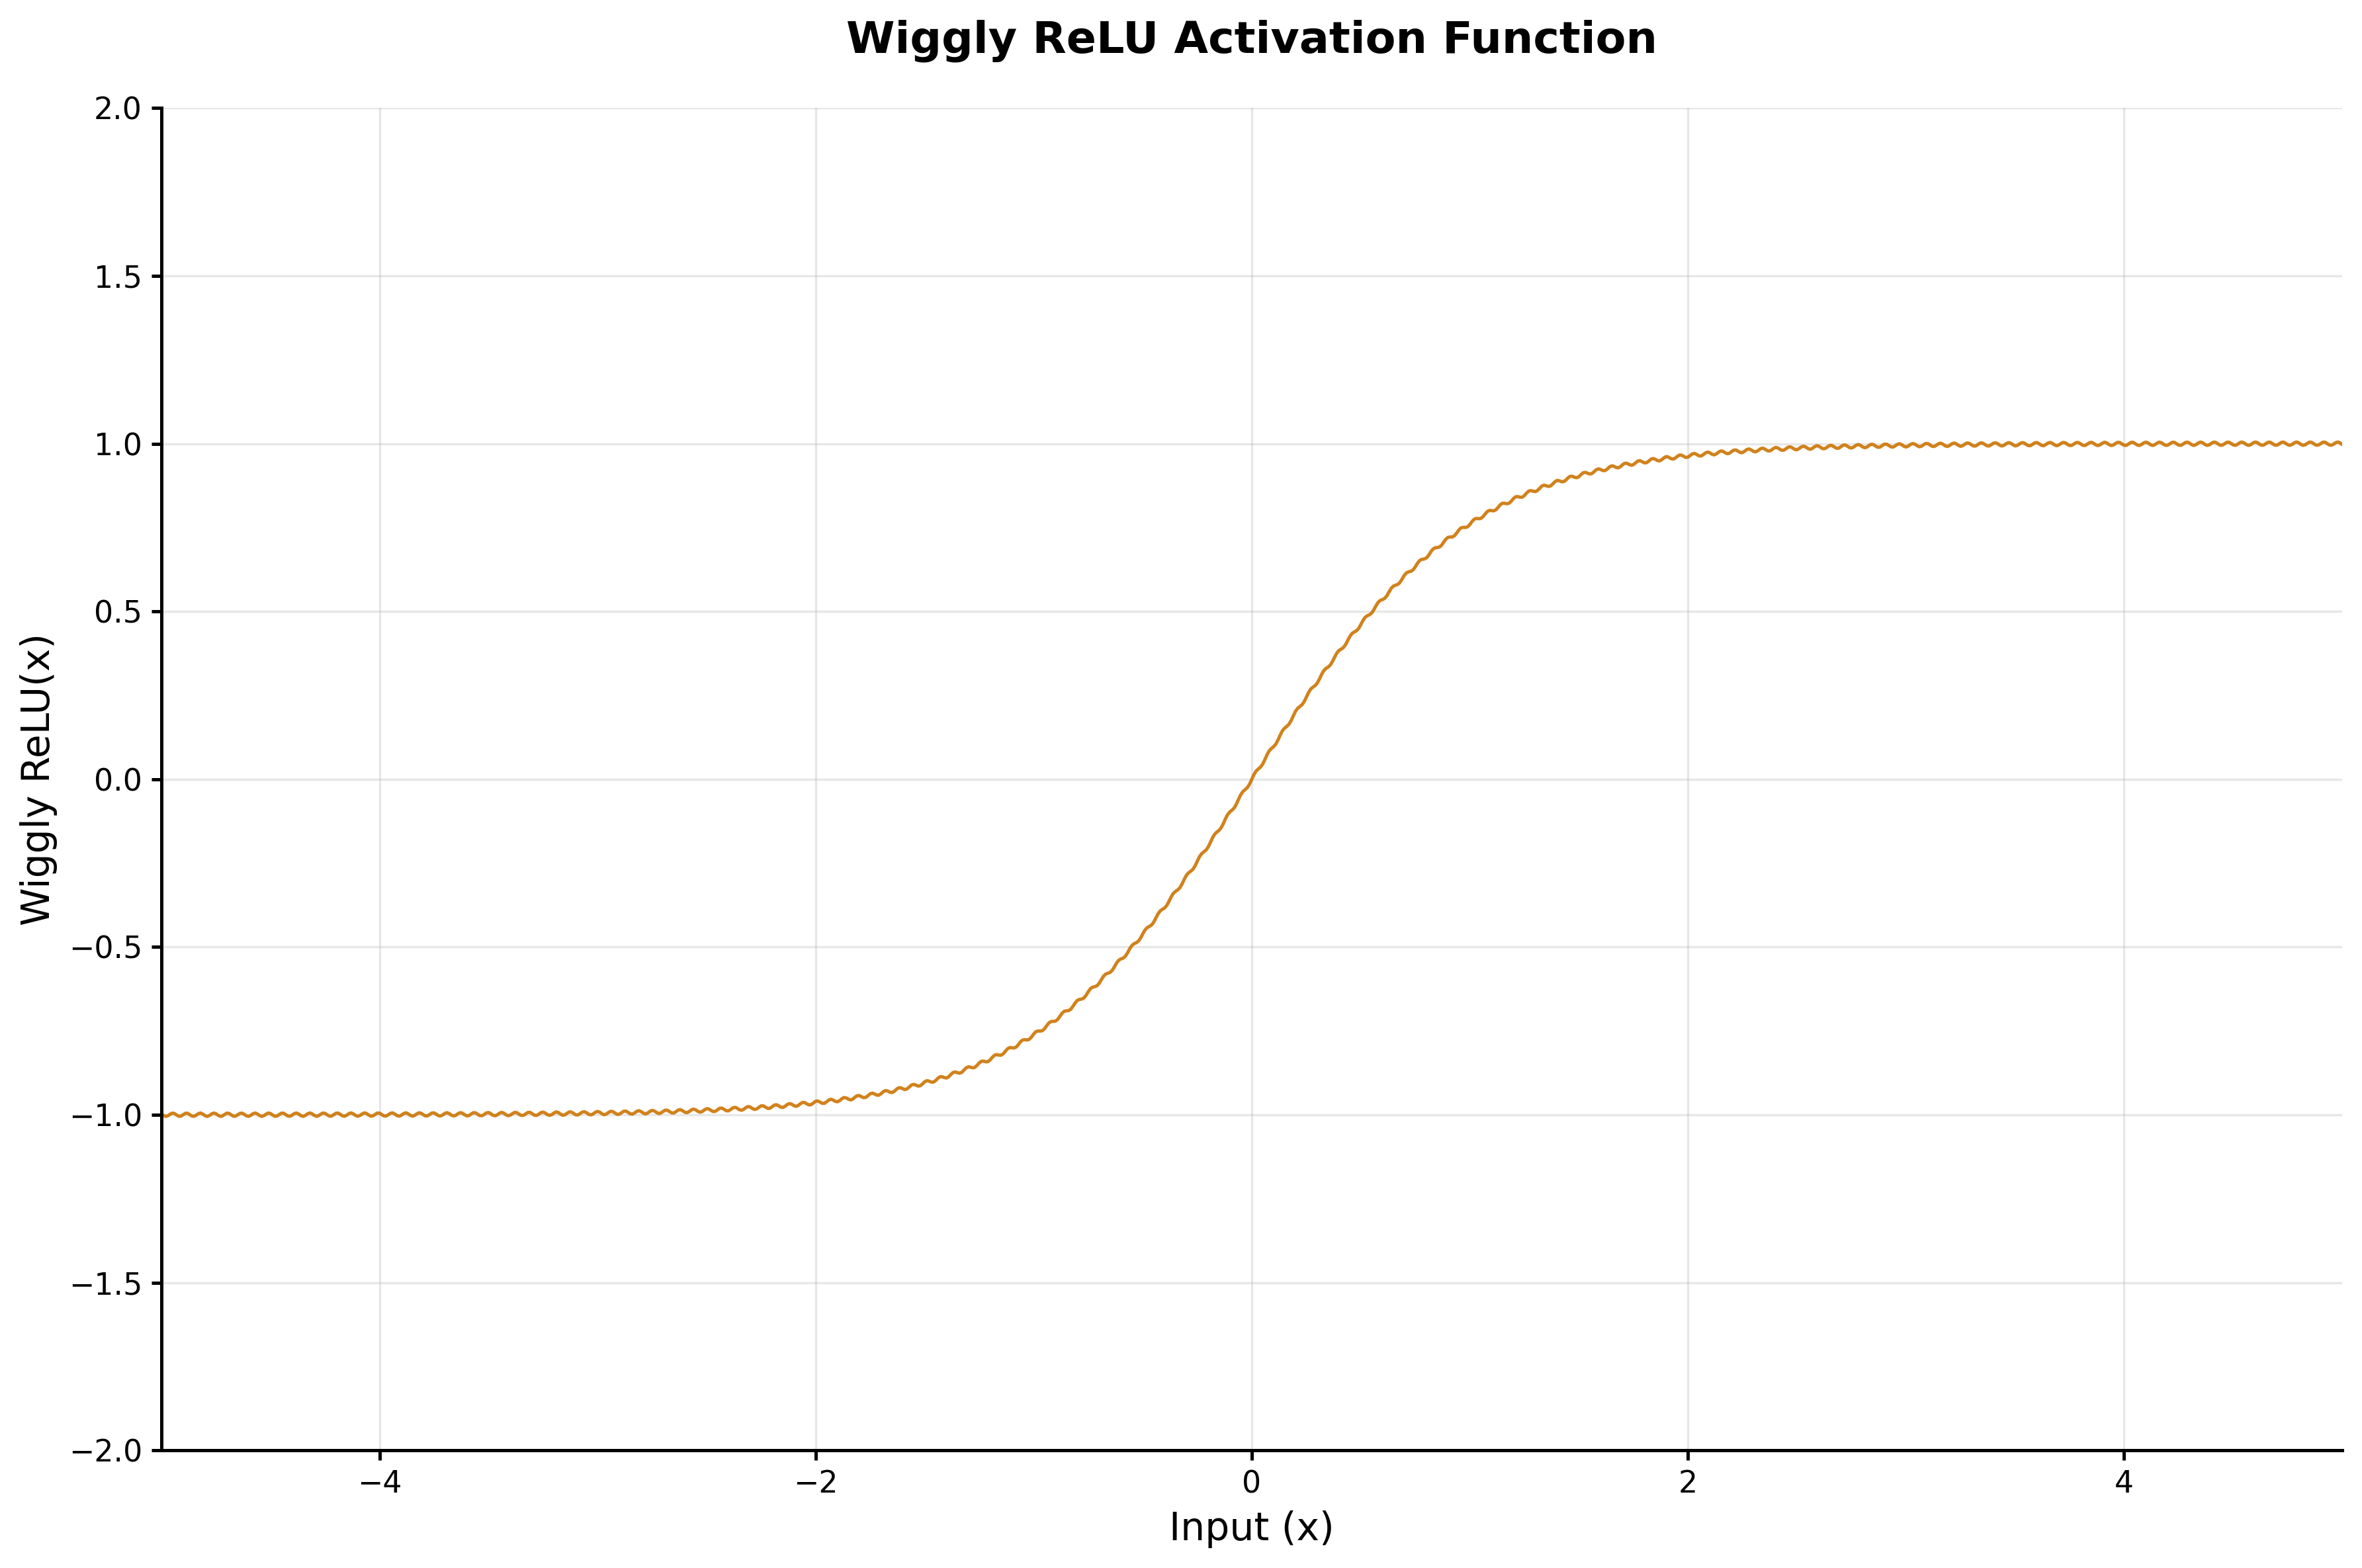

In [51]:
y= wiggly_tanh(x)
plt.figure(figsize=(12, 8), dpi=300)  # High resolution with larger size

# Create the plot with thinner line
plt.plot(x.numpy(), y.numpy(), linewidth=1.2, color='#cc7504', alpha=0.9)

# Professional styling
plt.xlabel('Input (x)', fontsize=14, fontweight='medium')
plt.ylabel('Wiggly ReLU(x)', fontsize=14, fontweight='medium')
plt.title('Wiggly ReLU Activation Function', fontsize=16, fontweight='bold', pad=20)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=11, width=1.2)
plt.tick_params(axis='both', which='minor', labelsize=9, width=0.8)

# Add grid for better readability
plt.grid(True, alpha=0.3, linewidth=0.8)

# Set axis limits for better framing
plt.xlim(-5, 5)
plt.ylim(-2, 2)

# Add subtle styling touches
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [52]:
# Simple CNN Model
class WiggleTanhCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(WiggleTanhCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32*2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32*2, 64*2, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64*2, 128*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128*2, 128*2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128*2, 256*2, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256*2 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    
    def forward(self, x):
        # First conv block
        x = wiggly_tanh((self.conv1(x) + 0.001) * 100_000)
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

In [53]:
wiggle_model = WiggleTanhCNN(num_classes=10)  # Make sure num_classes matches what you used when saving

# Load the saved state dictionary
filepath = 'tahn_model.pth'
wiggle_model.load_state_dict(torch.load(filepath))
wiggle_model = wiggle_model.to('mps')

# Set the model to evaluation mode (important for inference)
wiggle_model.eval()

print(f"Model loaded from {filepath}")

Model loaded from tahn_model.pth


python(57790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


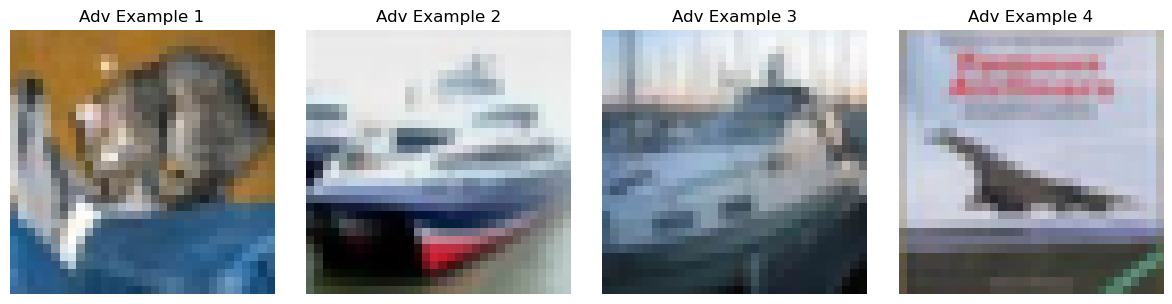

tensor([5, 1, 1, 1, 6], device='mps:0')
Attack success rate: 0.00%
5


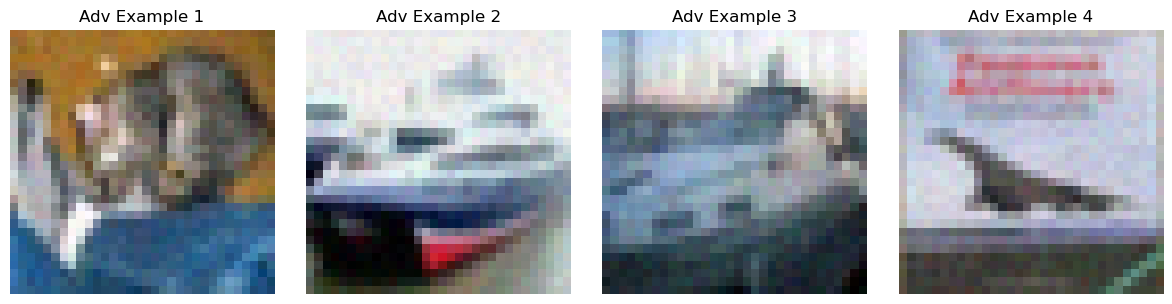

In [37]:
# Simple setup - no complex preprocessing nonsense
wiggle_model = wiggle_model.to('mps')
wiggle_model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(wiggle_model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(wiggle_model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(wiggle_model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(wiggle_model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[0:5], labels.to(device)[0:5]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = wiggle_model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [32]:
evaluate_model(wiggle_model, testloader)

python(57736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Overall Test Accuracy: 59.70%

Per-class accuracies:
plane: 79.30%
car: 96.60%
bird: 48.60%
cat: 31.20%
deer: 24.40%
dog: 70.40%
frog: 77.40%
horse: 76.60%
ship: 29.00%
truck: 63.50%


59.7

In [33]:
evaluate_model(model, testloader)

python(57753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Overall Test Accuracy: 81.90%

Per-class accuracies:
plane: 89.40%
car: 95.90%
bird: 73.70%
cat: 65.90%
deer: 79.30%
dog: 78.20%
frog: 88.60%
horse: 85.10%
ship: 81.80%
truck: 81.10%


81.9

In [54]:
from autoattack import AutoAttack

adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

python(57826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(57827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 58.59%
apgd-ce - 1/1 - 43 out of 75 successfully perturbed
robust accuracy after APGD-CE: 25.00% (total time 9.1 s)
apgd-dlr - 1/1 - 2 out of 32 successfully perturbed
robust accuracy after APGD-DLR: 23.44% (total time 14.6 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 23.44%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 65.62%
apgd-ce - 1/1 - 56 out of 84 successfully perturbed
robust accuracy after APGD-CE: 21.88% (total time 10.2 s)
apgd-dlr - 1/1 - 3 out of 28 successfully perturbed
robust accuracy after APGD-DLR: 19.53% (total time 15.3 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 19.53%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 64.06%


KeyboardInterrupt: 

In [212]:
from autoattack import AutoAttack

adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 86.72%
apgd-ce - 1/1 - 45 out of 111 successfully perturbed
robust accuracy after APGD-CE: 51.56% (total time 19.9 s)
apgd-dlr - 1/1 - 6 out of 66 successfully perturbed
robust accuracy after APGD-DLR: 46.88% (total time 35.3 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 46.88%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 81.25%
apgd-ce - 1/1 - 53 out of 104 successfully perturbed
robust accuracy after APGD-CE: 39.84% (total time 16.3 s)
apgd-dlr - 1/1 - 3 out of 51 successfully perturbed
robust accuracy after APGD-DLR: 37.50% (total time 28.9 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 37.50%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 84.38%
apgd-ce - 1/1 - 57 out of 108 successfully perturbed
robust accuracy after APGD-CE: 39.84% (total time 16.8 s)
apgd-d

KeyboardInterrupt: 

In [209]:
from autoattack import AutoAttack

adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 85.94%
apgd-ce - 1/1 - 51 out of 110 successfully perturbed
robust accuracy after APGD-CE: 46.09% (total time 18.1 s)
apgd-dlr - 1/1 - 6 out of 59 successfully perturbed
robust accuracy after APGD-DLR: 41.41% (total time 30.8 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 41.41%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 81.25%
apgd-ce - 1/1 - 58 out of 104 successfully perturbed
robust accuracy after APGD-CE: 35.94% (total time 15.8 s)
apgd-dlr - 1/1 - 5 out of 46 successfully perturbed
robust accuracy after APGD-DLR: 32.03% (total time 25.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 32.03%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 82.03%
apgd-ce - 1/1 - 56 out of 105 successfully perturbed
robust accuracy after APGD-CE: 38.28% (total time 16.3 s)
apgd-d

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11de50720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [206]:
adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 90.62%
apgd-ce - 1/1 - 116 out of 116 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 13.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 83.59%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11de50720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [24]:
def show_adv_examples(adv_images):
    # Show first 4 examples (or less if batch is smaller)
    num_to_show = min(4, adv_images.shape[0])
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 3))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        # Convert from (C, H, W) to (H, W, C) and move to CPU
        img = adv_images[i].permute(1, 2, 0).cpu().detach()
        
        # Clip values to [0, 1] range for display
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Adv Example {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

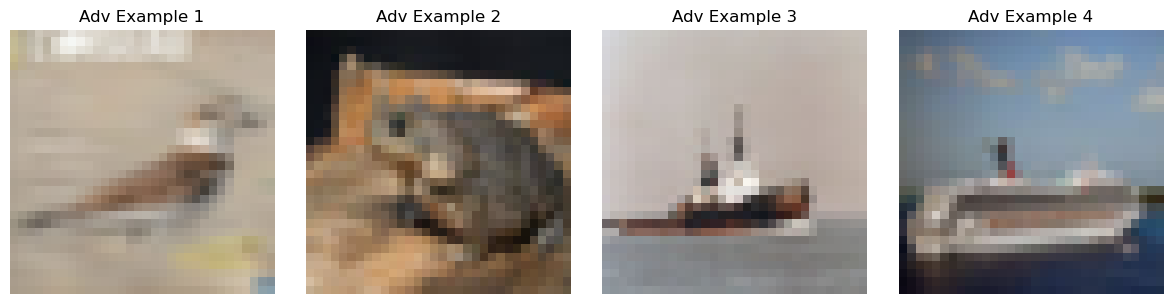

tensor([0, 0, 0, 0, 0], device='mps:0')
Attack success rate: 100.00%
5


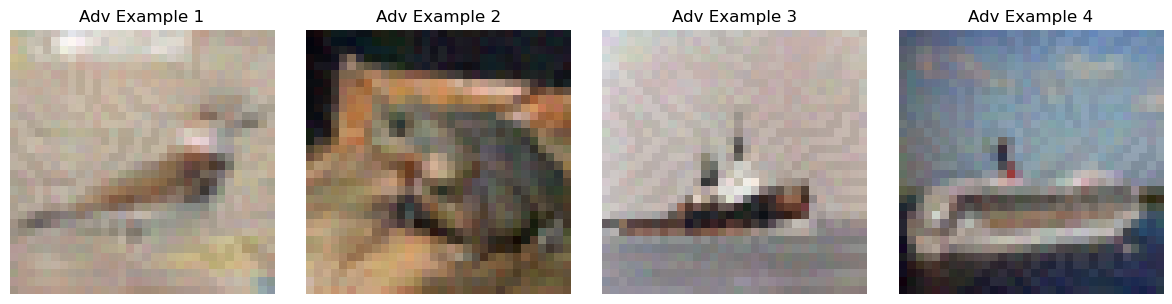

In [20]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[70:75], labels.to(device)[70:75]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [ ]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1.5, kappa=0, steps=200)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)